# Downloading and Unzipping Dataset

In [ ]:
# downloading
!wget -O dataset.zip "https://d3ilbtxij3aepc.cloudfront.net/projects/CDS-Capstone-Projects/PRCP-1001-RiceLeaf.zip"

--2025-11-07 13:24:10--  https://d3ilbtxij3aepc.cloudfront.net/projects/CDS-Capstone-Projects/PRCP-1001-RiceLeaf.zip
Resolving d3ilbtxij3aepc.cloudfront.net (d3ilbtxij3aepc.cloudfront.net)... 18.164.152.159, 18.164.152.31, 18.164.152.197, ...
Connecting to d3ilbtxij3aepc.cloudfront.net (d3ilbtxij3aepc.cloudfront.net)|18.164.152.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37520522 (36M) [application/x-zip-compressed]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  35.78M  30.9MB/s    in 1.2s    

2025-11-07 13:24:12 (30.9 MB/s) - ‘dataset.zip’ saved [37520522/37520522]



In [ ]:
# unzipping it
!unzip -o dataset.zip -d dataset/
!unzip -o "/content/dataset/Data/Bacterial leaf blight-20200814T055237Z-001.zip" -d data/
!unzip -o "/content/dataset/Data/Brown spot-20200814T055208Z-001.zip" -d data/
!unzip -o "/content/dataset/Data/Leaf smut-20200814T055530Z-001.zip" -d data/

Archive:  dataset.zip
  inflating: dataset/Data/Leaf smut-20200814T055530Z-001.zip  
  inflating: dataset/Data/Brown spot-20200814T055208Z-001.zip  
  inflating: dataset/Data/Bacterial leaf blight-20200814T055237Z-001.zip  
Archive:  /content/dataset/Data/Bacterial leaf blight-20200814T055237Z-001.zip
  inflating: data/Bacterial leaf blight/DSC_0406.JPG  
  inflating: data/Bacterial leaf blight/DSC_0405.JPG  
  inflating: data/Bacterial leaf blight/DSC_0404.JPG  
  inflating: data/Bacterial leaf blight/DSC_0403.JPG  
  inflating: data/Bacterial leaf blight/DSC_0402.JPG  
  inflating: data/Bacterial leaf blight/DSC_0401.JPG  
  inflating: data/Bacterial leaf blight/DSC_0400.JPG  
  inflating: data/Bacterial leaf blight/DSC_0399.JPG  
  inflating: data/Bacterial leaf blight/DSC_0398.JPG  
  inflating: data/Bacterial leaf blight/DSC_0397.JPG  
  inflating: data/Bacterial leaf blight/DSC_0395.JPG  
  inflating: data/Bacterial leaf blight/DSC_0393.JPG  
  inflating: data/Bacterial leaf blig

# Importing Packages

In [ ]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout, GlobalAveragePooling2D
from keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import (MobileNetV2, MobileNetV3Large, EfficientNetB0,
                                           ResNet50, InceptionV3, DenseNet121, EfficientNetV2B0, EfficientNetV2B1,
                                           EfficientNetV2B2, EfficientNetV2B3)

from sklearn.metrics import classification_report, confusion_matrix

import time

import warnings
warnings.filterwarnings('ignore')

# Loading Dataset

In [ ]:
DATA_DIR = '/content/data'
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

In [ ]:
# Using generators to load the data and split it in training and validation
train_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

validation_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 119 files belonging to 3 classes.
Using 96 files for training.
Found 119 files belonging to 3 classes.
Using 23 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']


# Visualize a few images

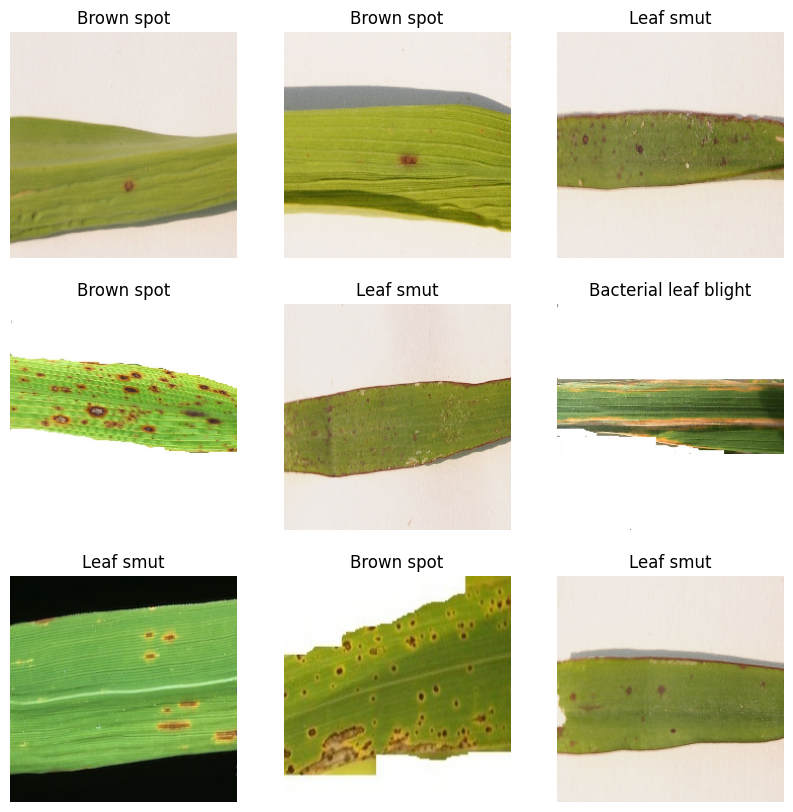

In [ ]:
# taking a copy of the train_ds
sample_ds = train_ds

plt.figure(figsize=(10, 10))
for img, label in sample_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(class_names[label[i]])
    plt.axis('off')

# Training

### Training without data augmentation and transfer learning

In [ ]:
model = Sequential([
    # Normalizing image
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),

    # Convolution layers
    Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),
    Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),
    Conv2D(128, kernel_size=(3, 3), padding='valid', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),

    # Flattening
    Flatten(),

    # Main layer
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,177,411 (42.64 MB)

 Trainable params: 11,177,411 (42.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, epochs=50, validation_data=validation_ds)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 422ms/step - accuracy: 0.2153 - loss: 1.4970 - val_accuracy: 0.2174 - val_loss: 1.1118
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.3933 - loss: 1.0861 - val_accuracy: 0.7391 - val_loss: 1.0532
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.4985 - loss: 1.0621 - val_accuracy: 0.4348 - val_loss: 1.0454
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.6132 - loss: 0.9568 - val_accuracy: 0.3478 - val_loss: 1.5087
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.5394 - loss: 0.9499 - val_accuracy: 0.6522 - val_loss: 0.9052
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - accuracy: 0.6451 - loss: 0.7913 - val_accuracy: 0.6522 - val_loss: 0.8568
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.7098 - loss: 0.7386 - val_accuracy: 0.6087 - val_loss: 0.7426
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.6805 - loss: 0.7408 - val_accuracy: 0.5217 - val_loss:

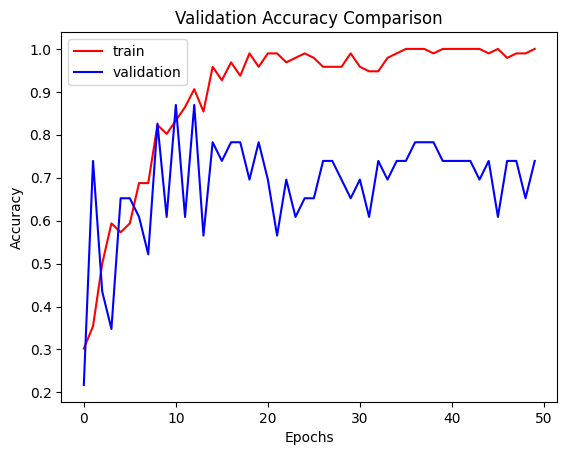

In [ ]:
# Visualizing the performance

plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

As we can see from the above graph that the model is overfitting and not performing very good.
So we need to implement data augmentation and transfer learning.

### Training with data augmentation

In [ ]:
# Data Augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.12),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.10)
])

In [ ]:
model_aug = Sequential([
    data_augmentation,

    layers.Rescaling(1./255, input_shape=(224, 224, 3)),

    Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),
    Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),
    Conv2D(128, kernel_size=(3, 3), padding='valid', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),
    Conv2D(256, kernel_size=(3, 3), padding='valid', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

In [ ]:
model_aug.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_aug.build((None, 224, 224, 3))

In [ ]:
model_aug.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,117,571 (19.52 MB)

 Trainable params: 5,117,571 (19.52 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_aug = model_aug.fit(train_ds, epochs=50, validation_data=validation_ds)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.3275 - loss: 1.1014 - val_accuracy: 0.2174 - val_loss: 1.1159
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.3789 - loss: 1.0956 - val_accuracy: 0.2174 - val_loss: 1.1203
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.3570 - loss: 1.0858 - val_accuracy: 0.3043 - val_loss: 1.1311
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.4315 - loss: 1.0761 - val_accuracy: 0.3043 - val_loss: 1.1311
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.4271 - loss: 1.0854 - val_accuracy: 0.2174 - val_loss: 1.1404
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.4699 - loss: 1.0820 - val_accuracy: 0.3478 - val_loss: 1.1392
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step - accuracy: 0.4634 - loss: 1.0736 - val_accuracy: 0.2174 - val_loss: 1.1476
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.3952 - loss: 1.1179 - val_accuracy: 0.2174 - val_loss:

In [ ]:
y_true = np.concatenate([y for _, y in validation_ds], axis=0)
y_pred = np.argmax(model_aug.predict(validation_ds), axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
                       precision    recall  f1-score   support

Bacterial leaf blight       0.22      0.29      0.25         7
           Brown spot       0.33      0.20      0.25         5
            Leaf smut       0.55      0.55      0.55        11

             accuracy                           0.39        23
            macro avg       0.37      0.34      0.35        23
         weighted avg       0.40      0.39      0.39        23



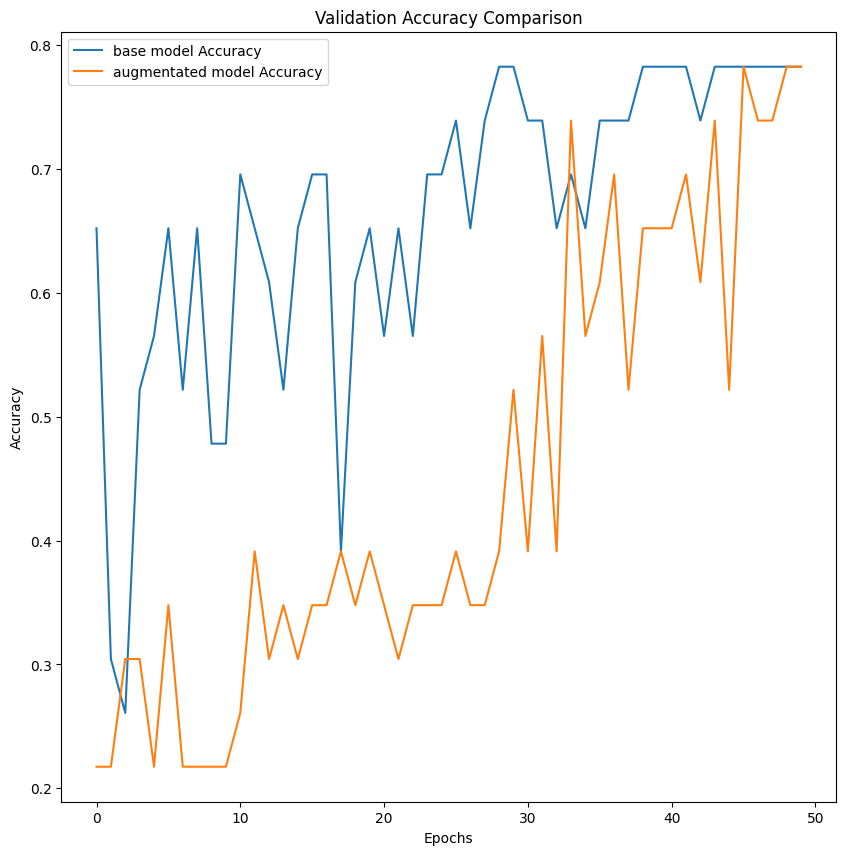

In [ ]:
# base model vs. augmentated model
plt.figure(figsize=(10, 10))
plt.plot(history.history['val_accuracy'], label='base model Accuracy')
plt.plot(history_aug.history['val_accuracy'], label='augmentated model Accuracy')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

As we can see that the augmented model(orange) is performing better than the normal model(blue).
But its taking time to generalize the model and get a better performance, mainly after 30-40 epochs, so lowering learning rate, adding BatchNormalization may help and increasing the epochs may help.

In [ ]:
callbacks = [
    # EarlyStopping(patience=15, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)
]

model_aug.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_aug.build((None, 224, 224, 3))

In [ ]:
model_aug.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,117,571 (19.52 MB)

 Trainable params: 5,117,571 (19.52 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_aug = model_aug.fit(train_ds, epochs=50, validation_data=validation_ds, callbacks=callbacks)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - accuracy: 0.3667 - loss: 1.0965 - val_accuracy: 0.2174 - val_loss: 1.1425 - learning_rate: 1.0000e-04
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.3911 - loss: 1.0904 - val_accuracy: 0.3043 - val_loss: 1.1331 - learning_rate: 1.0000e-04
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.3543 - loss: 1.1051 - val_accuracy: 0.3478 - val_loss: 1.1238 - learning_rate: 1.0000e-04
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.3823 - loss: 1.0759 - val_accuracy: 0.2174 - val_loss: 1.1627 - learning_rate: 1.0000e-04
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step - accuracy: 0.4187 - loss: 1.0983 - val_accuracy: 0.3043 - val_loss: 1.1250 - learning_rate: 1.0000e-04
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.5320 - loss: 1.0342 - val_accuracy: 0.3913 - val_loss: 1.0988 - learning_rate: 1.0000e-04
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - accuracy: 0.4662 - loss

In [ ]:
y_true = np.concatenate([y for _,y in validation_ds], axis=0)
y_pred = model_aug.predict(validation_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step


In [ ]:
print(classification_report(y_true, y_pred_classes, target_names=class_names))

                       precision    recall  f1-score   support

Bacterial leaf blight       0.33      0.43      0.38         7
           Brown spot       0.00      0.00      0.00         5
            Leaf smut       0.20      0.18      0.19        11

             accuracy                           0.22        23
            macro avg       0.18      0.20      0.19        23
         weighted avg       0.20      0.22      0.21        23



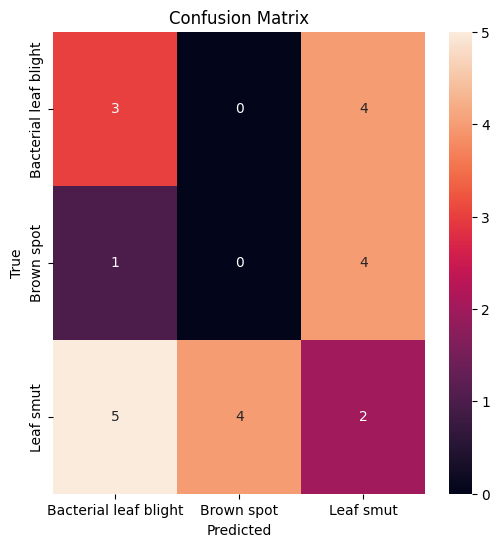

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


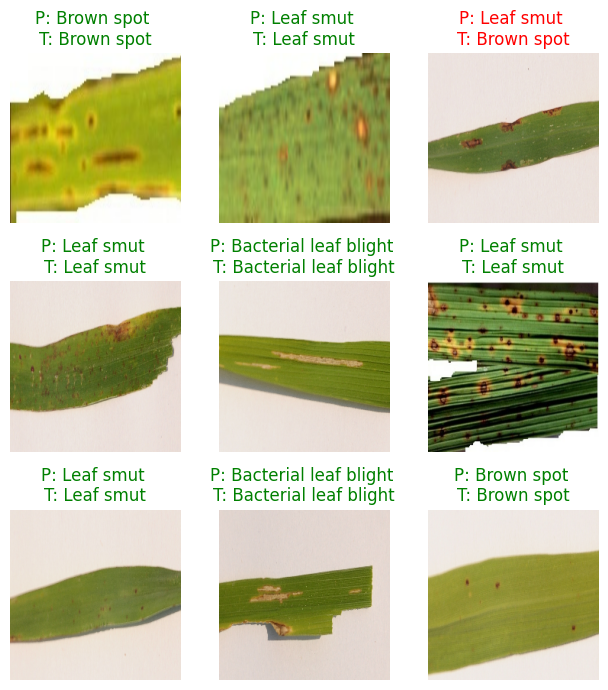

In [ ]:
sample_val_ds = validation_ds
plt.figure(figsize=(7, 7))
for image, label in sample_val_ds.take(1):
  preds = model_aug.predict(image)
  pred_labels = np.argmax(preds, axis=1)

  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image[i].numpy().astype("uint8"))
    true_label = class_names[label[i]]
    pred_label = class_names[pred_labels[i]]
    color = 'green' if pred_label == true_label else 'red'
    plt.title(f'P: {pred_label} \nT: {true_label}', color=color)
    plt.axis('off')
    plt.tight_layout()
plt.show()

After training the CNN model achieved a performance between 72% and 82% across multiple runs, indicating better generalization and stable performance, that too without transfer learning.


And from the above visualization we can observe that the model is good in predicting `Bacterial Leaf Blight` but not very good in predicting `Leaf Smut` and `Brown Spot`, likely becuase both diseases produce small and similar colored lesions. To address this we will use transfer learning along with data augmentation.

### Training with Transefer Learning

#### MobileNetV2

In [ ]:
base_mobile = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_mobile.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_mobile(x, training=False)
x = GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(3, activation='softmax')(x)
model_mobilenet = tf.keras.Model(inputs, outputs)

In [ ]:
model_mobilenet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_mobilenet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,619,203 (9.99 MB)

 Trainable params: 361,219 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history_mobilenet = model_mobilenet.fit(train_ds, epochs=20, validation_data=validation_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)])

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.4497 - loss: 1.3738 - val_accuracy: 0.7391 - val_loss: 0.6179
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.8612 - loss: 0.5167 - val_accuracy: 0.6522 - val_loss: 0.6308
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.9001 - loss: 0.2389 - val_accuracy: 0.7826 - val_loss: 0.3934
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.9781 - loss: 0.1106 - val_accuracy: 0.9130 - val_loss: 0.3469
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.9738 - loss: 0.0794 - val_accuracy: 0.7826 - val_loss: 0.3729
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - accuracy: 1.0000 - loss: 0.0603 - val_accuracy: 0.6957 - val_loss: 0.5945
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 1.0000 - loss: 0.0235 - val_accuracy: 0.8696 - val_loss: 0.3855
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.9830 - loss: 0.0278 - val_accuracy: 0.8696 - val_loss: 0

As we can see the range of validation accuacy increased to 78%-86.9% (sometimes touching 91%). Now we'll let the last 50 layers of the MobileNet model to train and check if the performance is increasing or not.

In [ ]:
base_mobile.trainable=True
for layer in base_mobile.layers[:-30]:
  layer.trainable = False

model_mobilenet.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_mobilenet.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_3 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_3 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,619,203 (9.99 MB)

 Trainable params: 1,887,619 (7.20 MB)

 Non-trainable params: 731,584 (2.79 MB)

In [ ]:
# checking which layers have trainable=True
for i,layer in enumerate(base_mobile.layers):
  print(i, layer, layer.trainable)

0 <InputLayer name=input_layer_4, built=True> False
1 <Conv2D name=Conv1, built=True> False
2 <BatchNormalization name=bn_Conv1, built=True> False
3 <ReLU name=Conv1_relu, built=True> False
4 <DepthwiseConv2D name=expanded_conv_depthwise, built=True> False
5 <BatchNormalization name=expanded_conv_depthwise_BN, built=True> False
6 <ReLU name=expanded_conv_depthwise_relu, built=True> False
7 <Conv2D name=expanded_conv_project, built=True> False
8 <BatchNormalization name=expanded_conv_project_BN, built=True> False
9 <Conv2D name=block_1_expand, built=True> False
10 <BatchNormalization name=block_1_expand_BN, built=True> False
11 <ReLU name=block_1_expand_relu, built=True> False
12 <ZeroPadding2D name=block_1_pad, built=True> False
13 <DepthwiseConv2D name=block_1_depthwise, built=True> False
14 <BatchNormalization name=block_1_depthwise_BN, built=True> False
15 <ReLU name=block_1_depthwise_relu, built=True> False
16 <Conv2D name=block_1_project, built=True> False
17 <BatchNormalization n

In [ ]:
history_mobilenet_tuned = model_mobilenet.fit(train_ds, epochs=50, validation_data=validation_ds)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 432ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.7826 - val_loss: 0.8243
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.7391 - val_loss: 0.9070
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.7391 - val_loss: 0.8656
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 1.0000 - loss: 3.9468e-04 - val_accuracy: 0.7391 - val_loss: 0.8785
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 1.0000 - loss: 9.0148e-04 - val_accuracy: 0.7391 - val_loss: 0.8553
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.7391 - val_loss: 0.8747
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.9970 - loss: 0.0116 - val_accuracy: 0.7391 - val_loss: 0.8364
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.9766 - loss: 0.0474 - val_accuracy: 0.8261 - 

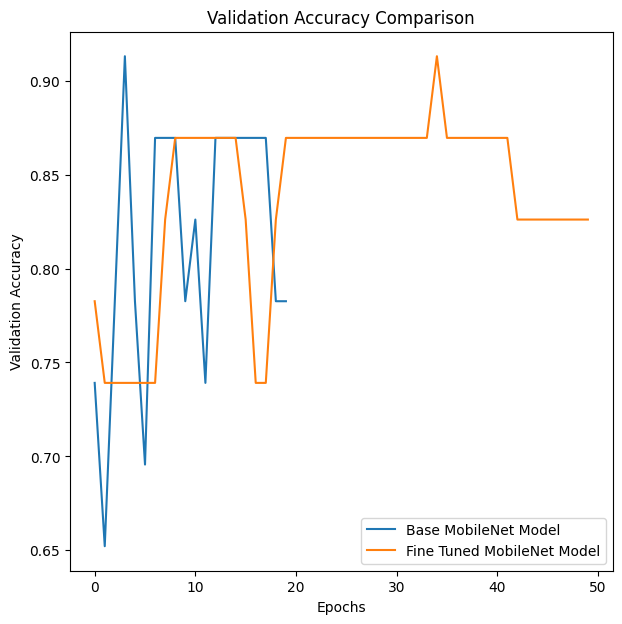

In [ ]:
# base model vs. augmentated model
plt.figure(figsize=(7, 7))
plt.plot(history_mobilenet.history['val_accuracy'], label='Base MobileNet Model')
plt.plot(history_mobilenet_tuned.history['val_accuracy'], label='Fine Tuned MobileNet Model')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

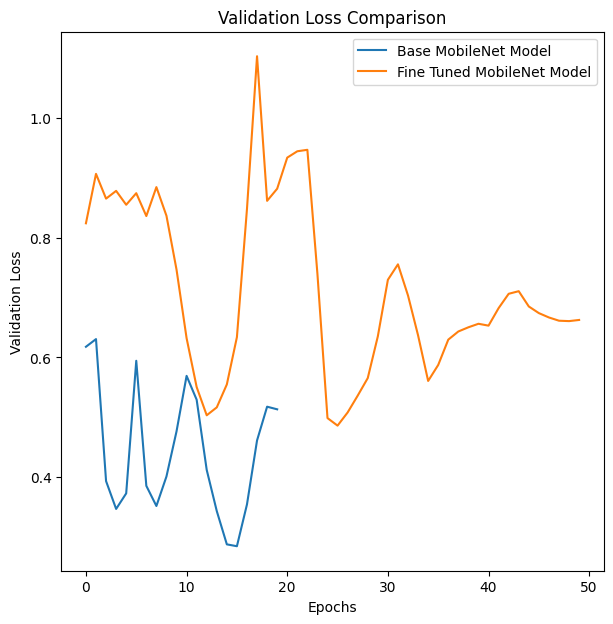

In [ ]:
# base model vs. augmentated model
plt.figure(figsize=(7, 7))
plt.plot(history_mobilenet.history['val_loss'], label='Base MobileNet Model')
plt.plot(history_mobilenet_tuned.history['val_loss'], label='Fine Tuned MobileNet Model')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

From the above two graphs, we an see that the fine-tuned model of MobileNet was able to gain a stable validation accuracy of almost 86% with little fluctuation from 82%-91%.

We tried with making last 50 layers as trainable=True and with RMSprop with learning rate of 1e-5 but it didnt help, so we reduced the trainable layer of MobileNet model to 30 and changed the optimizer to Adam with learning rate=1-4, and it gained an stable accuracy of 86%.

Now we will use other pretrained models and compare their performance and chose final model based on that.

In [ ]:
def build_transfer_model(model_class, preprocess_func, input_shape=(224, 224, 3), trainable_layer=30):
  base_model = model_class(weights='imagenet', include_top=False, input_shape=input_shape)
  base_model.trainable = True
  for layer in base_model.layers[:-trainable_layer]:
    base_model.trainable = False

  inputs = tf.keras.Input(shape=input_shape)
  x = data_augmentation(inputs)
  x = preprocess_func(x)
  x = base_model(x, training=False)
  x = GlobalAveragePooling2D()(x)
  x = BatchNormalization()(x)
  x = layers.Dense(256, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = layers.Dense(128, activation='relu')(x)
  x = Dropout(0.2)(x)
  outputs = Dense(3, activation='softmax')(x)

  model = tf.keras.models.Model(inputs, outputs)
  return model

MobileNetV3Large, EfficientNetB0, ResNet50, InceptionV3, DenseNet121

In [ ]:
models_list = {
    "MobileNetV3Large": (MobileNetV3Large, tf.keras.applications.mobilenet_v3.preprocess_input),
    "EfficientNetB0": (EfficientNetB0, tf.keras.applications.efficientnet.preprocess_input),
    "ResNet50": (ResNet50, tf.keras.applications.resnet50.preprocess_input),
    "InceptionV3": (InceptionV3, tf.keras.applications.inception_v3.preprocess_input),
    "DenseNet121": (DenseNet121, tf.keras.applications.densenet.preprocess_input)
}

In [ ]:
results = {}
callback = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_accuracy')
]

for name, (base_class, preprocess_func) in models_list.items():
  print(f"\n Training: {name}...")
  model = build_transfer_model(base_class, preprocess_func)
  model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  start = time.time()
  history = model.fit(train_ds, validation_data=validation_ds, epochs=30, callbacks=callback, verbose=1)
  end = time.time()

  best_val_acc = max(history.history['val_accuracy'])
  results[name] = {
      "val_accuracy": best_val_acc,
      "train_time": end - start,
      "history": history
  }

  print(f"{name} finished with val_accuracy of {best_val_acc:.4f}, Time: {(end - start)/60:.2f} mins")


 Training: MobileNetV3Large...
Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 571ms/step - accuracy: 0.3673 - loss: 1.2817 - val_accuracy: 0.5217 - val_loss: 0.9543
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.5019 - loss: 1.0598 - val_accuracy: 0.4783 - val_loss: 0.8896
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.5219 - loss: 0.9419 - val_accuracy: 0.4783 - val_loss: 0.8276
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.6022 - loss: 0.7521 - val_accuracy: 0.4783 - val_loss: 0.7866
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.7213 - loss: 0.6646 - val_accuracy: 0.5652 - val_loss: 0.7421
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - accuracy: 0.7403 - loss: 0.7121 - val_accuracy: 0.6087 - val_loss: 0.7016
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - accuracy: 0.7500 - loss: 0.6301 - val_accuracy: 0.6957 - val_loss: 0.6704
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.8085 - loss: 0.5796 -

In [ ]:
results

{'MobileNetV3Large': {'val_accuracy': 0.9130434989929199,
  'train_time': 38.3780472278595,
  'history': <keras.src.callbacks.history.History at 0x7cd3b08cb230>},
 'EfficientNetB0': {'val_accuracy': 0.9130434989929199,
  'train_time': 26.87590193748474,
  'history': <keras.src.callbacks.history.History at 0x7cd431847e60>},
 'ResNet50': {'val_accuracy': 0.9130434989929199,
  'train_time': 40.23594546318054,
  'history': <keras.src.callbacks.history.History at 0x7cd430d43560>},
 'InceptionV3': {'val_accuracy': 0.6086956262588501,
  'train_time': 35.51800012588501,
  'history': <keras.src.callbacks.history.History at 0x7cd3aad8f650>},
 'DenseNet121': {'val_accuracy': 0.782608687877655,
  'train_time': 45.885685443878174,
  'history': <keras.src.callbacks.history.History at 0x7cd343ee0350>}}

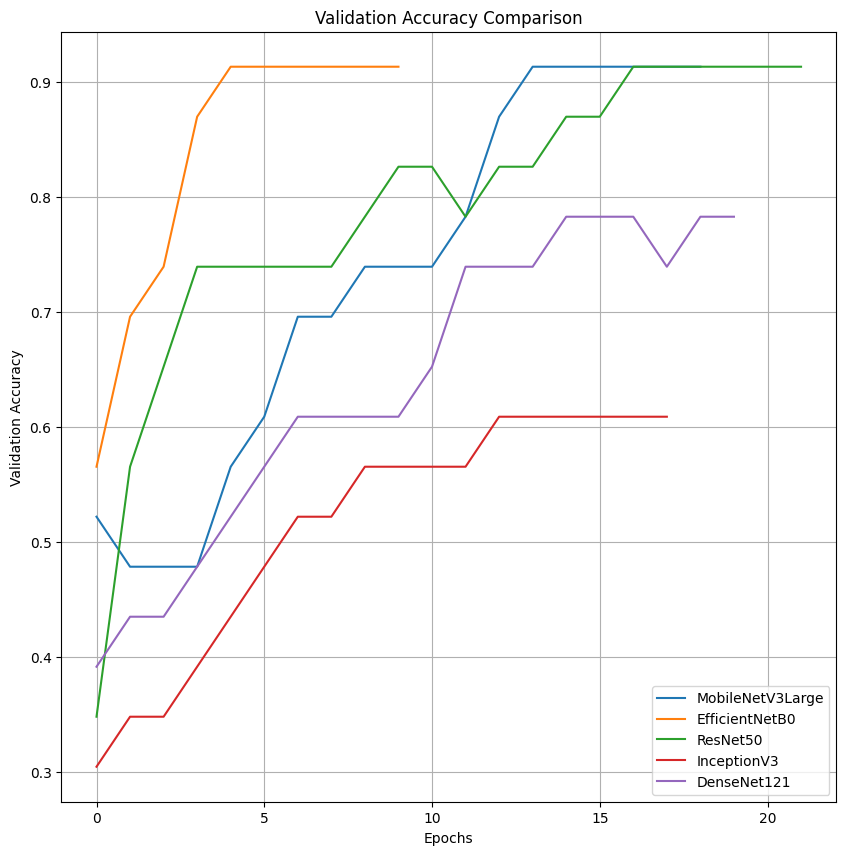

In [ ]:
plt.figure(figsize=(10, 10))
for name, res in results.items():
  plt.plot(res["history"].history['val_accuracy'], label=f'{name}')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
for name, res in results.items():
  print(f"{name:15s} - Best val accuracy: {res['val_accuracy']*100:.2f}% - Time: {res['train_time']/60} mins")

MobileNetV3Large - Best val accuracy: 91.30% - Time: 0.639634120464325 mins
EfficientNetB0  - Best val accuracy: 91.30% - Time: 0.447931698958079 mins
ResNet50        - Best val accuracy: 91.30% - Time: 0.6705990910530091 mins
InceptionV3     - Best val accuracy: 60.87% - Time: 0.5919666687647501 mins
DenseNet121     - Best val accuracy: 78.26% - Time: 0.7647614240646362 mins


From the above comparison of various pretrained models, we can see that the EfficientNetB0 is the model with best performance with lowest training time.

Now we will fine-tune EfficientNetB0 and will also try EfficientNetb1, EfficientNetb2 and EfficientNetB3, to see if the performance is further increasing or not.

#### EffiecientNetB0

In [ ]:
base_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_efficientnet.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x) # EfficientNetB0 Preprocessing
x = base_efficientnet(x, training=False) # EfficientNetB0
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(3, activation='softmax')(x)
model_efficientnet = tf.keras.Model(inputs, outputs) # EfficientNetB0 Model

In [ ]:
# Custom function to fetch the desired percent of layers from the model
def layer_trainable(model, percentage):
  return int(len(model.layers) * percentage)

In [ ]:
base_efficientnet.trainable=True
for layer in base_efficientnet.layers[:-(layer_trainable(base_efficientnet, 0.25))]:
  layer.trainable = False

model_efficientnet.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_efficientnet.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_100         │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,415,910 (16.85 MB)

 Trainable params: 3,033,539 (11.57 MB)

 Non-trainable params: 1,382,371 (5.27 MB)

In [ ]:
history_effiientnet_tuned = model_efficientnet.fit(train_ds, validation_data=validation_ds, epochs=50)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 641ms/step - accuracy: 0.4881 - loss: 1.1077 - val_accuracy: 0.3913 - val_loss: 1.1164
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.6199 - loss: 0.7844 - val_accuracy: 0.6087 - val_loss: 1.0462
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.7103 - loss: 0.6796 - val_accuracy: 0.6957 - val_loss: 0.9833
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 346ms/step - accuracy: 0.7341 - loss: 0.6107 - val_accuracy: 0.7391 - val_loss: 0.9265
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.8781 - loss: 0.4243 - val_accuracy: 0.7391 - val_loss: 0.8733
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.9320 - loss: 0.2791 - val_accuracy: 0.7391 - val_loss: 0.8263
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.8414 - loss: 0.4378 - val_accuracy: 0.7391 - val_loss: 0.7801
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.8649 - loss: 0.3335 - val_accuracy: 0.7391 - val_loss

EfficientNetV2B1, EfficientNetV2B2, EfficientNetV2B3

In [ ]:
efficientnet_models = {
    "EfficientNetV2B0": (EfficientNetV2B0, tf.keras.applications.efficientnet_v2.preprocess_input),
    "EfficientNetV2B1": (EfficientNetV2B1, tf.keras.applications.efficientnet_v2.preprocess_input),
    "EfficientNetV2B2": (EfficientNetV2B2, tf.keras.applications.efficientnet_v2.preprocess_input),
    "EfficientNetV2B3": (EfficientNetV2B3, tf.keras.applications.efficientnet_v2.preprocess_input)
}

In [ ]:
efficientnet_results = {}
callback = [
    tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_accuracy', restore_best_weights=True)
]

for name, (base_class, preprocess_func) in efficientnet_models.items():
  print(f"Training: {name}...")
  model = build_transfer_model(base_class, preprocess_func)
  model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  start = time.time()
  history = model.fit(train_ds, validation_data=validation_ds, epochs=30, callbacks=callback, verbose=1)
  end = time.time()

  best_val_acc = max(history.history['val_accuracy'])
  efficientnet_results[name] = {
      "val_accuracy": best_val_acc,
      "train_time": end - start,
      "history": history
  }

  print(f"{name} finished with val_accuracy of {best_val_acc:.4f}, Time: {(end - start)/60:.2f} mins")

Training: EfficientNetV2B0...
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 769ms/step - accuracy: 0.4074 - loss: 1.4748 - val_accuracy: 0.3913 - val_loss: 1.1722
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.4579 - loss: 1.1201 - val_accuracy: 0.4783 - val_loss: 1.1214
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.5374 - loss: 1.1109 - val_accuracy: 0.4783 - val_loss: 1.0636
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.5469 - loss: 0.9988 - val_accuracy: 0.4783 - val_loss: 1.0129
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.6926 - loss: 0.7523 - val_accuracy: 0.4783 - val_loss: 0.9722
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - accuracy: 0.7624 - loss: 0.6667 - val_accuracy: 0.5217 - val_loss: 0.9305
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - accuracy: 0.8064 - loss: 0.5290 - val_accuracy: 0.5652 - val_loss: 0.8970
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 

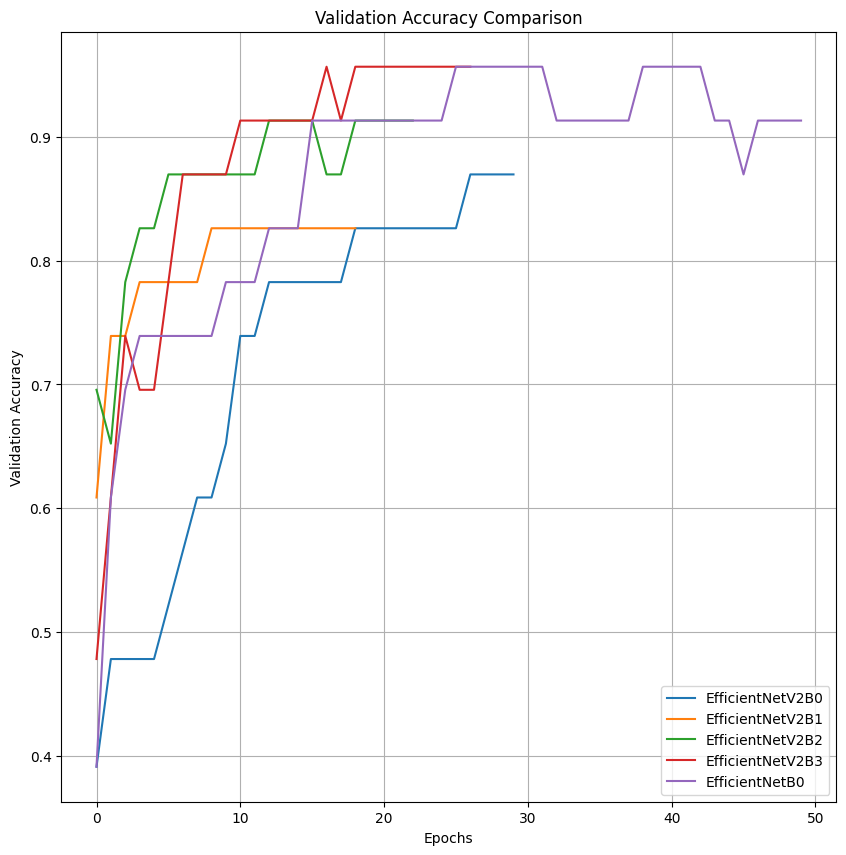

In [ ]:
plt.figure(figsize=(10, 10))
for name, res in efficientnet_results.items():
  plt.plot(res["history"].history['val_accuracy'], label=f'{name}')
plt.plot(history_effiientnet_tuned.history['val_accuracy'], label="EfficientNetB0")
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
for name, res in efficientnet_results.items():
  print(f"{name:15s} - Best val accuracy: {res['val_accuracy']*100:.2f}% - Time: {res['train_time']/60} mins")

EfficientNetV2B0 - Best val accuracy: 86.96% - Time: 0.8877702116966247 mins
EfficientNetV2B1 - Best val accuracy: 82.61% - Time: 0.7822461167971293 mins
EfficientNetV2B2 - Best val accuracy: 91.30% - Time: 0.8328259229660034 mins
EfficientNetV2B3 - Best val accuracy: 95.65% - Time: 0.9765623052914937 mins


In [ ]:
base_efficientnetv2 = EfficientNetV2B3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_efficientnetv2.trainable = False

52606240/52606240 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x) # EfficientNetV2B3 Preprocessing
x = base_efficientnetv2(x, training=False) # EfficientNetV2B3
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(3, activation='softmax')(x)
model_efficientnetv2 = tf.keras.Model(inputs, outputs) # EfficientNetV2B3 Model

In [ ]:
base_efficientnetv2.trainable = True
for layer in base_efficientnetv2.layers[:-(layer_trainable(base_efficientnetv2, 0.25))]:
  layer.trainable = False

model_efficientnetv2.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_efficientnetv2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, 7, 7, 1536)     │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,363,521 (50.98 MB)

 Trainable params: 6,239,801 (23.80 MB)

 Non-trainable params: 7,123,720 (27.17 MB)

In [ ]:
history_effiientnetv2_tuned = model_efficientnetv2.fit(train_ds, validation_data=validation_ds, epochs=50)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9667 - loss: 0.0671 - val_accuracy: 0.8696 - val_loss: 0.3170
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - accuracy: 0.9970 - loss: 0.0155 - val_accuracy: 0.8696 - val_loss: 0.3207
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - accuracy: 0.9786 - loss: 0.0283 - val_accuracy: 0.8696 - val_loss: 0.3372
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.9856 - loss: 0.0421 - val_accuracy: 0.9130 - val_loss: 0.3272
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - accuracy: 1.0000 - loss: 0.0082 - val_accuracy: 0.9130 - val_loss: 0.3399
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 1.0000 - loss: 0.0076 - val_accuracy: 0.8696 - val_loss: 0.3416
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 1.0000 - loss: 0.0067 - val_accuracy: 0.8696 - val_loss: 0.3162
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 0.8696 - val_loss: 0

## Final Evaluation and Conclusion

### Model Performance Overview

Multiple models were trained and evaluated to classify three rice plant diseases - *Bacterial Leaf Blight*, *Brown Spot *and* Leaf Smut*. Initially we used basic CNN and achieved only a validation accuracy of around 35% due to the small dataset size and lack of generalization.

Applying **data augmentation** and **transfer learning** significantly helped in improving the results. Tested architectures include - MobileNetV2, MobileNetV3Large, EfficientNetB0, ResNet50, InceptionV3, DenseNet121, EfficientNetV2B0, EfficientNetV2B1, EfficientNetV2B2, EfficientNetV2B3 - the **EfficientNetV2B3** model achieved the best validation accuracy of around 95%, with consistent stability around 86-91% across multiple runs. This model gae better performance than the more complex and bigger models, with relatively small training time.

### Interpretation

The high and stable validation accuracy suggests that the model successfully generalized to unseen images.

While doing only data augmentation, the model was getting confused in  *Brown Spot* and *Leaf Smut*, which shared similar brown patches and lesion.

Using transfer learning with data augmentation helped the model a lot in classifying the different types of leaf textures, patches and color intensity.

1. Data Augmentation:
Random horizontal flips, slight rotations, zoom and contrast adjustments helped in increasing data diversity, reducing overfitting.
2. Transfer Learning:
Using pretrained ImageNet weights in EfficientNetV2B3 provided a strong feature representation, requiring only fine-tuning of the upper 25% layers for
domain specific adaptation.
3. Fine-Tuning Impact:
After training the top 25% layer of the model helped in improing both accuracy and model robustness, giving stable validation accuracy.
4. Optimization and Regularization:
Using the adam optimizer with learning rate of 1e-4 along with batch Normalization and Dropout layers(0.2) helped maintain stable convergence and give a stable performance.

### Conclusion

EfficientNetV2B3 proved to be the most efficient and accurate architecture for this small dataset, offering a robust solution for automated rice leaf detection.

Future work may include expanding the dataset, employing Grad-CAM for visual explainability, and deploying the model as lightweight mobile or web-based diagonastic tool for real-world agricultural use.